# Tabulation API Example: Methane Shear Layer

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


In this demonstration we show how to build several adiabatic chemistry models for running a flow-resolved shear layer DNS calculation. We can easily dilute the methane fuel with Nitrogen to set the stoichiometric mixture fraction to 0.5, and further set the density of the air stream to control the momentum ratio across the shear layer. Spitfire and Cantera make it easy to set this up. After generating the tables we use Cantera to compute quantities like the density and the chemical heat release rate.

In [1]:
from spitfire import (ChemicalMechanismSpec,
                      FlameletSpec,
                      build_adiabatic_eq_library, 
                      build_adiabatic_bs_library, 
                      build_adiabatic_slfm_library)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mech = ChemicalMechanismSpec(cantera_input='methane-lu30.yaml', group_name='methane-lu30')

pressure = 101325.

ch4 = mech.stream('TPY', (298., pressure, 'CH4:1'))
n2 = mech.stream('TPY', (298., pressure, 'N2:1'))
air = mech.stream(stp_air=True)

Next we mix the methane and nitrogen streams so that the stoichiometric mixture fraction (with air as the oxidizer) is 0.5, using a built-in Spitfire method.

Then the densities of the fuel and air streams are equated with the Cantera `DP` (density and pressure) setting, allowing the temperature to change.

In [3]:
fuel = mech.mix_fuels_for_stoich_mixture_fraction(ch4, n2, 0.5, air)
air.DP = fuel.density, pressure

Next we set up our flamelet specifications and build equilibrium, Burke-Schumann, and SLFM libraries with the high-level API.

Note that in this example we set `verbose=True`, which shows tabulation progress, and `solver_verbose=False`, which hides internal details of the solvers, on the SLFM call. Setting `solver_verbose=True` to see internal solver details would show that this configuration, because the high stoichiometric mixture fraction leads to an extremely weak flame, is challenging to solve. The most aggressive solvers try and fail on this problem and it ultimately is solved (less quickly) by a transient approach to the steady state with implicit Runge-Kutta methods. Typically this is unnecessary.

In [4]:
flamelet_specs = FlameletSpec(mech_spec=mech, 
                              initial_condition='equilibrium',
                              oxy_stream=air,
                              fuel_stream=fuel,
                              grid_points=128)

l_eq = build_adiabatic_eq_library(flamelet_specs, verbose=False)
l_bs = build_adiabatic_bs_library(flamelet_specs, verbose=False)
l_sl = build_adiabatic_slfm_library(flamelet_specs,
                                    diss_rate_values=np.logspace(-4, np.log10(2), 36),
                                    diss_rate_ref='stoichiometric',
                                    verbose=True,
                                    solver_verbose=False)

----------------------------------------------------------------------------------
building adiabatic SLFM library
----------------------------------------------------------------------------------
- mechanism: methane-lu30.yaml
- 30 species, 184 reactions
- stoichiometric mixture fraction: 0.500
----------------------------------------------------------------------------------
   1/  36 (chi_stoich =  1.0e-04 1/s) 

 converged in   4.14 s, T_max = 1505.4
   2/  36 (chi_stoich =  1.3e-04 1/s)  converged in   0.05 s, T_max = 1504.8
   3/  36 (chi_stoich =  1.8e-04 1/s)  converged in   0.08 s, T_max = 1504.5
   4/  36 (chi_stoich =  2.3e-04 1/s)  converged in   0.11 s, T_max = 1504.1
   5/  36 (chi_stoich =  3.1e-04 1/s)  converged in   1.80 s, T_max = 1503.7
   6/  36 (chi_stoich =  4.1e-04 1/s)  converged in   1.68 s, T_max = 1503.2
   7/  36 (chi_stoich =  5.5e-04 1/s)  converged in   0.04 s, T_max = 1502.8
   8/  36 (chi_stoich =  7.2e-04 1/s)  converged in   0.99 s, T_max = 1502.2
   9/  36 (chi_stoich =  9.6e-04 1/s)  converged in   0.05 s, T_max = 1501.6
  10/  36 (chi_stoich =  1.3e-03 1/s)  converged in   0.06 s, T_max = 1501.0
  11/  36 (chi_stoich =  1.7e-03 1/s)  converged in   0.05 s, T_max = 1500.2
  12/  36 (chi_stoich =  2.2e-03 1/s)  converged in   0.05 s, T_max = 1499.4
  13/  36 (chi_stoich =  3.0e-03 1/s)  converged in   0.04 s, T_max = 1498.6
  14/  36 (chi_stoich =  4.0e-03 1/s)

In [5]:
from spitfire import get_ct_solution_array
from cantera import gas_constant as Ru

def add_density_to_library(lib):
    ctsol, shape = get_ct_solution_array(mech, lib)
    lib['density'] = ctsol.density_mass.reshape(shape)
    
def add_hrr_to_library(lib):
    ctsol, shape = get_ct_solution_array(mech, lib)
    
    w = ctsol.net_production_rates
    h = ctsol.standard_enthalpies_RT * Ru * np.array([ctsol.T]).T
    
    lib['heat_release_rate'] = - np.sum(w * h, axis=1).reshape(shape)

In [6]:
for l in [l_bs, l_eq, l_sl]:
    add_density_to_library(l)
    add_hrr_to_library(l)

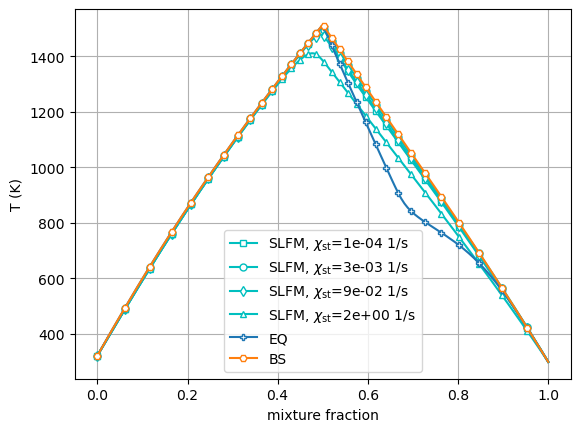

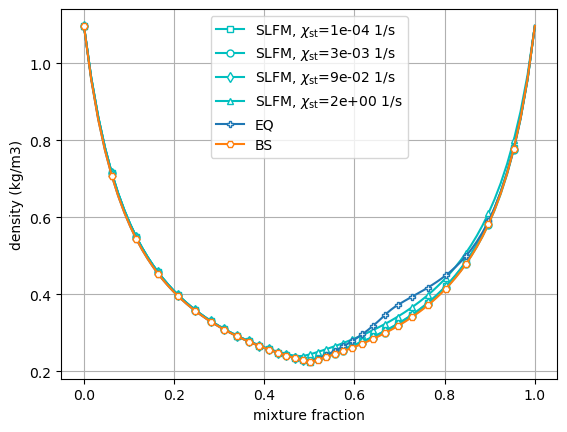

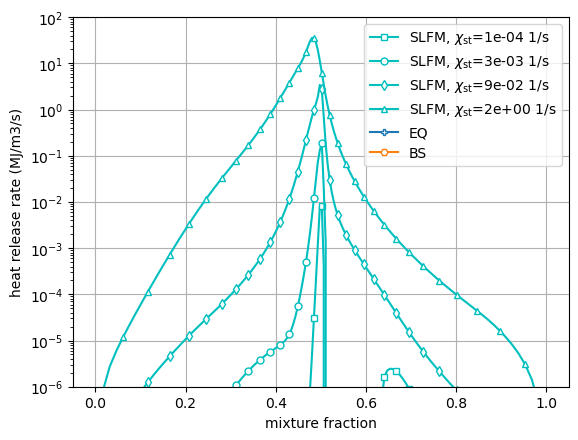

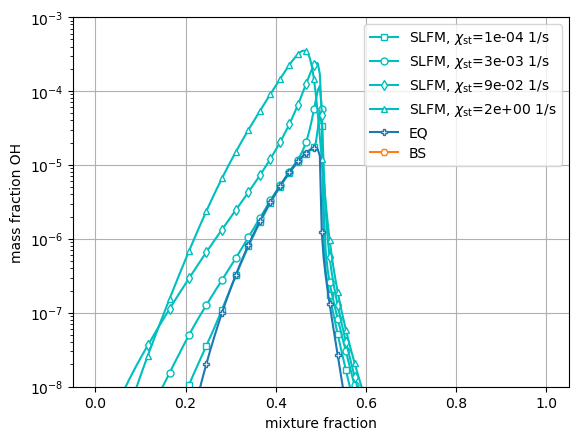

In [7]:
chi_indices_plot = [0, 12, 24, 35]
chi_values = l_sl.dim('dissipation_rate_stoich').values
z = l_sl.dim('mixture_fraction').values

for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['temperature'][:, ix], 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['temperature'], 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['temperature'], 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.xlabel('mixture fraction')
plt.ylabel('T (K)')
plt.grid(True)
plt.legend(loc='best')
plt.show()

for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['density'][:, ix], 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['density'], 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['density'], 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.xlabel('mixture fraction')
plt.ylabel('density (kg/m3)')
plt.grid(True)
plt.legend(loc='best')
plt.show()

for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['heat_release_rate'][:, ix] / 1.e6, 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['heat_release_rate'] / 1.e6, 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['heat_release_rate'] / 1.e6, 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.yscale('log')
plt.ylim([1e-6, 1e2])
plt.xlabel('mixture fraction')
plt.ylabel('heat release rate (MJ/m3/s)')
plt.grid(True)
plt.legend(loc='best')
plt.show()

plt.figure()
for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['mass fraction OH'][:, ix], 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['mass fraction OH'], 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['mass fraction OH'], 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.yscale('log')
plt.ylim([1e-8, 1e-3])
plt.xlabel('mixture fraction')
plt.ylabel('mass fraction OH')
plt.grid(True)
plt.legend(loc='best')
plt.show()
